# **Анализ репозиториев в GitHub**

## 1. Введение
### 1.1 Цель исследования
Собрать данные о популярных GitHub-репозиториях по тегам AI и ML с помощью веб-парсинга результатов глобального поиска GitHub, провести очистку данных, создание новых признаков и исследовательский анализ, чтобы выявить закономерности популярности open-source проектов.

### 1.2 Источник данных

Мы выполняем парсинг HTML-страниц глобального поиска GitHub:

Глобальный поиск по тегу AI:
https://github.com/search?q=AI&type=repositories&s=stars&o=desc

Глобальный поиск по тегу ML:
https://github.com/search?q=ML&type=repositories&s=stars&o=desc

### 1.3 Описание предметной области

GitHub — крупнейшая платформа для open-source разработки.
Мы анализируем репозитории, отсортированные по популярности (метрика: количество звёзд, сортировка Most stars → по убыванию).
Это позволяет выявлять факторы, связанные с востребованностью проектов в области AI/ML.

---
### 1.4 Требования и результат

| Требование                             | Результат |
|:--------------------------------------:|:-----------------------------:|
| Количество наблюдений  > 1000          | 2000+                         |
| Начальное количество признаков >= 8-10 | 10                            |
| Типы признаков                         |                               |
| Количество новых признаков >= 2        |                               |
| Финальное количество признаков         |                               |
| Визуализации >= 3                      |                               |
| Итоговый формат                        | Jupyter/Colab notebook + .CSV |
| [дополнительно] Репозиторий на github  | ссылка                        |


### 1.5 Технологии проекта

| Технология          | Документация                                       |
| :------------------ | :------------------------------------------------: |
| Python 3.12.12      | https://docs.python.org/3/                         |
| pandas              | https://pandas.pydata.org/docs/                    |
| NumPy               | https://numpy.org/doc/                             |
| requests            | https://requests.readthedocs.io/                   |
| BeautifulSoup (bs4) | https://beautiful-soup-4.readthedocs.io/en/latest/ |
| time (stdlib)       | https://docs.python.org/3/library/time.html        |
| random (stdlib)     | https://docs.python.org/3/library/random.html      |
| itertools (stdlib)  | https://docs.python.org/3/library/itertools.html   |
| pathlib (stdlib)    | https://docs.python.org/3/library/pathlib.html     |
| types.NoneType      | https://docs.python.org/3/library/types.html       |


### 1.6 Команда и распределение задач

| Участник                         | Обязанности                         |
|----------------------------------|-------------------------------------|
| **Трофимов Матвей Владимирович** | Сбор, парсинг, первичные выводы     |
| **Самунджян Дина Арменаковна**   | Очистка данных, пропуски, дубликаты |
| **Серенко Елена Валерьевна**     | Создание новых признаков            |
| **Пащенко Дмитрий Игоревич**     | Визуализации, выводы и  результаты  |


### Структура ноутбука

```markdown
# 1. Введение
## 1.1 Цель проекта
## 1.2 Источник данных
## 1.3 Описание предметной области
## 1.4 Требования к датасету
## 1.5 Технологии проекта
## 1.6 Команда и распределение задач

Трофимов Матвей Владимирович  
### 2. Этап 0 — Сбор и парсинг данных
2.1 получение данных через парсинг
2.2 формирование датасета и сохранение `название.csv`
2.3 краткий просмотр результата и промежуточные выводы

Самунджян Дина Арменаковна  
### 3. Этап 1 — Очистка данных
3.1 обработка пропусков, дубликатов, выбросов
3.2 приведение типов данных
3.3 сохранение `название.csv`
3.4 краткие промежуточные выводы

Серенко Елена Валерьевна  
### 4. Этап 2 — Создание новых признаков
4.1 создание дополнительных признаков (не менее двух)
4.2 формирование `название.csv`
4.3 краткие промежуточные выводы

Пащенко Дмитрий Игоревич  
### 5. Этап 3 — Анализ данных (EDA) и визуализация
5.1 описательная статистика, группировки, корреляции
5.2 визуализации (не менее трёх разных типов)
5.3 интерпретация результатов и промежуточные выводы

### 6. Итоговые выводы исследования (все участники)
```

# Парсинг репозиториев с GitHub

# МАТВЕЙ

In [ ]:
"""
Этот код монтирует удаленную папку на диске с доступом для всех.
Далее все аутпуты файлов делайте в эту папку /content/drive/MyDrive/Colab Notebooks, чтобы у всех был доступ.
"""

from google.colab import drive
drive.mount('/content/drive')  # один раз на сеанс запустить, подтвердить доступ
shared_dir = '/content/drive/MyDrive/Colab Notebooks'  # путь к общей папке

Mounted at /content/drive


In [22]:
import sys
import requests
import time
import pandas as pd
import random
import bs4
from bs4 import BeautifulSoup
from types import NoneType
import itertools
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("requests:", requests.__version__)
print("pandas:", pd.__version__)
print("bs4:", bs4.__version__)
print("numpy:", np.__version__)
print("sns:", sns.__version__)
print("matplotlib:", matplotlib.__version__)

Python: 3.12.12
requests: 2.32.4
pandas: 2.2.2
bs4: 4.13.5
numpy: 2.0.2
sns: 0.13.2
matplotlib: 3.10.0


### В рамках парсинга были созданы две вспомогательные функции:

**`repository_parsing(url)`**  
Функция принимает URL репозитория GitHub и с помощью HTTP‑запроса и библиотеки BeautifulSoup извлекает его параметры: название, описание, языки программирования, количество форков, звезд, коммитов, пул‑реквестов, контрибьюторов и релизов. При ошибке парсинга или отсутствии нужных элементов возвращает `None`, чтобы проблемные репозитории можно было безопасно пропустить при массовом сборе данных.

**`get_df_from_github(repositories_count)`**  
Функция выполняет массовый сбор данных о репозиториях по запросу `AI` и `ML` в поиске GitHub, обходя до 100 страниц выдачи с паузами между запросами. Для каждой найденной ссылки вызывается `repository_parsing`, а собранные параметры добавляются в списки до достижения заданного количества репозиториев `repositories_count`, после чего формируется `pandas.DataFrame` с основными метриками и ссылками на репозитории.

In [ ]:
# Получаем на вход ссылку на репозиторий в GitHub, парсим его и возвращаем лист с его параметрами
def repository_parsing(url):
    try:
        print(f'Парсим репозиторий: {url}')
        site1 = requests.get(url)
        site_text = site1.content.decode('utf-8')
        soup = BeautifulSoup(site_text, 'html.parser')
        split_url = url.split('/')
        repository_name = split_url[-2] + ' ' + split_url[-1]
        contributors = 0 # кол-во контрибьюторов репозитория
        releases = 0 # кол-во релизов репозитория
        for a in soup.find_all('a', class_='Link--primary no-underline Link'): # Находим информацию о кол-ве релизов репозитория
            splitted = a.text.split()
            if splitted[0] == 'Releases' and len(splitted) > 1:
                releases = int(splitted[1].replace(',', '').replace("+", ""))

        for a in soup.find_all('a', class_='Link--primary no-underline Link d-flex flex-items-center'): # Находим информацию о кол-ве котрибьюторов репозитория
            splitted = a.text.split()
            if splitted[0] == 'Contributors' and len(splitted) > 1:
                contributors = int(splitted[1].replace(',', '').replace("+", ""))

        languages = [] # список языков программирования, которые использовались в данном репозитории
        for span in soup.find_all('span', 'color-fg-default text-bold mr-1'):
            languages.append(span.text)

        pull_requests = 0 # кол-во пул реквестов в репозитории
        fork_amount = 0 # кол-во форков в репозитории
        stars_amount = 0 # кол-во звезд репозитория
        commits_amount = 0 # кол-во коммитов в репозитории

        if soup.find('p', class_='f4 my-3') != NoneType: # проверка наличия элемента на странице
            repository_description = soup.find('p', class_='f4 my-3').text.strip()

        if soup.find('span', class_='Counter', id='pull-requests-repo-tab-count') != NoneType: # проверка наличия элемента на странице
            pull_requests = int(soup.find('span', class_='Counter', id='pull-requests-repo-tab-count').get('title').replace(',', ''))

        if soup.find('span', id="repo-network-counter") != NoneType: # проверка наличия элемента на странице
            fork_amount = int(soup.find('span', id="repo-network-counter").get('title').replace(',', ''))

        if soup.find('span', id="repo-stars-counter-star") != NoneType: # проверка наличия элемента на странице
            stars_amount = int(soup.find('span', id="repo-stars-counter-star").get('title').replace(',', ''))

        if soup.find('span', class_='fgColor-default') != NoneType: # проверка наличия элемента на странице
            commits_amount = int(soup.find('span', class_='fgColor-default').text.split()[0].replace(',', ''))
        # возвращаем список с параметрами репозитория
        return [repository_name, repository_description, languages, fork_amount, stars_amount, commits_amount, pull_requests, contributors, releases, url]

    except Exception as e: # обработка ошибок при парсинге репозитория
        print(f"Ошибка при парсинге {url}: {e}")
        return None

In [ ]:
def get_df_from_github(repositories_count, query_tag):
    names = [] # список для названий репозиториев
    descriptions = [] # список для описаний репозиториев
    languages = [] # список языков программирования, используемых в репозитории
    fork_amounts = [] # список кол-ва форков в репозитории
    stars_amounts = [] # список кол-ва звезд репозитория
    commits_amounts = [] # список кол-ва коммитов в репозитории
    pull_requests_amounts = [] # список кол-ва пул-реквестов в репозитории
    contributors_amounts = [] # список кол-ва контрибьюторов репозитория
    releases_amounts = [] # список кол-ва релизов в репозитории
    urls = [] # список с ссылками на репозитории
    source_path = 'https://github.com'
    cur_repositories_count = 0
    site1 = requests.get(f'https://github.com/search?q={query_tag}&type=repositories&s=stars&o=desc')
    pages_count = repositories_count // 10 if repositories_count % 10 == 0 else repositories_count // 10 + 1
    i = 0
    while i < pages_count: # проверка, что номер страницы не больше 100, пагинация больше 100 страниц недоступна
      i += 1
      if (i != 1):
        time.sleep(10) # иммитация работы человека, пауза в работе кода на 10 сек
      print(f'Парсим репозитории с данного url: https://github.com/search?q=AI&type=repositories&s=stars&o=desc&p={i}')
      site1 = requests.get(f'https://github.com/search?q=AI&type=repositories&s=stars&o=desc&p={i}')
      print(f'Страница получена, с кодом ответа: {site1.status_code}')
      while (site1.status_code != 200): # продолжаем запрос страницы пока она не будет возвращена со статусом 200
        time.sleep(10)
        site1 = requests.get(f'https://github.com/search?q=AI&type=repositories&s=stars&o=desc&p={i}')
        print(f'Страница получена, с кодом ответа: {site1.status_code}')
      site_text = site1.content.decode('utf-8')
      soup = BeautifulSoup(site_text, 'html.parser')
      for link in soup.find_all('a', class_='Link__StyledLink-sc-1syctfj-0 prc-Link-Link-85e08'):
          if cur_repositories_count == repositories_count: # выход из цикла при достаточном кол-ве обработанных репозиториев
              break
          repository_stat = repository_parsing(source_path + link.get('href'))
          if repository_stat == None: # если обработать репозиторий не удалось переходим к следующему
            continue
          cur_repositories_count += 1
          # сохраняем полученную информацию
          names.append(repository_stat[0])
          descriptions.append(repository_stat[1])
          languages.append(repository_stat[2])
          fork_amounts.append(repository_stat[3])
          stars_amounts.append(repository_stat[4])
          commits_amounts.append(repository_stat[5])
          pull_requests_amounts.append(repository_stat[6])
          contributors_amounts.append(repository_stat[7])
          releases_amounts.append(repository_stat[8])
          urls.append(repository_stat[9])
    df = pd.DataFrame({
        'Name': names,
        'Description': descriptions,
        'Programming languages': languages,
        'Forks count': fork_amounts,
        'Stars count': stars_amounts,
        'Commits count': commits_amounts,
        'Pull requests count': pull_requests_amounts,
        'Contributors count': contributors_amounts,
        'Releases counts': releases_amounts,
        'Url': urls
    })
    return df

In [ ]:
#df1 = get_df_from_github(1000) # передаем кол-во репозиториев, которое хотим спарсить
df2 = get_df_from_github(25, 'AI')



Парсим репозитории с данного url: https://github.com/search?q=AI&type=repositories&s=stars&o=desc&p=1
Страница получена, с кодом ответа: 200
Парсим репозиторий: https://github.com/Significant-Gravitas/AutoGPT
Парсим репозиторий: https://github.com/n8n-io/n8n
Парсим репозиторий: https://github.com/AUTOMATIC1111/stable-diffusion-webui
Парсим репозиторий: https://github.com/langflow-ai/langflow
Парсим репозиторий: https://github.com/langchain-ai/langchain
Парсим репозиторий: https://github.com/langgenius/dify
Парсим репозиторий: https://github.com/open-webui/open-webui
Парсим репозиторий: https://github.com/microsoft/generative-ai-for-beginners
Парсим репозиторий: https://github.com/x1xhlol/system-prompts-and-models-of-ai-tools
Парсим репозиторий: https://github.com/comfyanonymous/ComfyUI
Парсим репозитории с данного url: https://github.com/search?q=AI&type=repositories&s=stars&o=desc&p=2
Страница получена, с кодом ответа: 200
Парсим репозиторий: https://github.com/supabase/supabase
Парси

In [ ]:
# df1.to_csv('github_repositories.csv', index=False) # сохраняем локально
df1.to_csv(f'/content/drive/MyDrive/Colab Notebooks/github_repositories1.csv', index=False) # сохраняем в общую папку в google drive
df2.to_csv(f'/content/drive/MyDrive/Colab Notebooks/github_repositories2.csv', index=False) # сохраняем в общую папку в google drive

NameError: name 'df1' is not defined

Совмещаем полученные датасеты в один.

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/github_AI_repositories.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/github_ML_repositories.csv')

df = pd.concat([df1, df2], ignore_index=True)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/github_repositories.csv', index=False)

# ДИНА

###Преобразование столбца Programming languages

In [27]:
df = pd.read_csv("github_repositories.csv")

def parse_languages(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return [str(v).strip() for v in x if str(v).strip()]

    s = str(x).strip()
    if s in ("", "[]", "nan", "None"):
        return []

    if s.startswith("[") and s.endswith("]"):
        inner = s[1:-1].strip()
        if inner == "":
            return []
        parts = inner.split(",")
        langs = []
        for p in parts:
            p = p.strip()
            if (p.startswith("'") and p.endswith("'")) or (p.startswith('"') and p.endswith('"')):
                p = p[1:-1]
            p = p.strip()
            if p:
                langs.append(p)
        return langs

    return [s] if s else []

df["Programming languages"] = df["Programming languages"].apply(parse_languages)

# флаг: языков нет
df["languages_missing"] = df["Programming languages"].apply(len).eq(0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Столбец Programming languages приведён к структурированному виду (список языков в каждой записи). Дополнительно создан флаг languages_missing для контроля записей, где языки отсутствуют.

###Общий обзор данных

In [28]:
print("Shape:", df.shape)
df.head()

Shape: (1953, 11)


,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,languages_missing
0,Significant-Gravitas AutoGPT,AutoGPT is the vision of accessible AI for eve...,"[Python, TypeScript, Dart, JavaScript, PLpgSQL...",46180,180076,7606,86,783,83,https://github.com/Significant-Gravitas/AutoGPT,False
1,n8n-io n8n,Fair-code workflow automation platform with na...,"[TypeScript, Vue, SCSS, Python, JavaScript, Ha...",51326,160338,16635,657,567,446,https://github.com/n8n-io/n8n,False
2,AUTOMATIC1111 stable-diffusion-webui,Stable Diffusion web UI,"[Python, JavaScript, CSS, HTML, Other]",29467,158707,7689,65,586,27,https://github.com/AUTOMATIC1111/stable-diffus...,False
3,langflow-ai langflow,Langflow is a powerful tool for building and d...,"[Python, TypeScript, JavaScript, CSS, Makefile...",8108,140120,16936,569,328,273,https://github.com/langflow-ai/langflow,False
4,langchain-ai langchain,🦜🔗 The platform for reliable agents.,"[Python, Jupyter Notebook, Makefile, Shell, XS...",19957,121028,14834,113,3812,1096,https://github.com/langchain-ai/langchain,False


### Обзор структуры

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Name                   1953 non-null   object
 1   Description            1953 non-null   object
 2   Programming languages  1953 non-null   object
 3   Forks count            1953 non-null   int64 
 4   Stars count            1953 non-null   int64 
 5   Commits count          1953 non-null   int64 
 6   Pull requests count    1953 non-null   int64 
 7   Contributors count     1953 non-null   int64 
 8   Releases counts        1953 non-null   int64 
 9   Url                    1953 non-null   object
 10  languages_missing      1953 non-null   bool  
dtypes: bool(1), int64(6), object(4)
memory usage: 154.6+ KB


In [30]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,1953,1894,bentoml BentoML,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,1953,1891,The easiest way to serve AI apps and models - ...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Programming languages,1953,968,[],227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Forks count,1953.0,NaN,NaN,NaN,1253.392217,3681.290379,0.0,151.0,432.0,1005.0,75030.0
Stars count,1953.0,NaN,NaN,NaN,7895.65745,15022.157347,305.0,804.0,3523.0,7836.0,192703.0
Commits count,1953.0,NaN,NaN,NaN,2083.133129,8025.524757,1.0,94.0,389.0,1545.0,200324.0
Pull requests count,1953.0,NaN,NaN,NaN,23.566308,78.706212,0.0,1.0,4.0,16.0,1866.0
Contributors count,1953.0,NaN,NaN,NaN,64.550435,196.741258,0.0,4.0,16.0,52.0,3812.0
Releases counts,1953.0,NaN,NaN,NaN,49.441372,224.819775,0.0,0.0,1.0,29.0,5000.0
Url,1953,1894,https://github.com/bentoml/BentoML,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Обработка пропусков

In [31]:
for col in ["Name", "Description", "Url"]:
    if col in df.columns:
        df[col] = df[col].replace(r"^\s*$", np.nan, regex=True)

Пустые значения нормализованы: в текстовых колонках пустые строки заменены на NaN, при этом структурные данные не затрагиваются.

In [32]:
if "Description" in df.columns:
    df["Description"] = df["Description"].fillna("")

Description: пропуски заполнены пустой строкой "" (чтобы анализ текста не ломался).

In [33]:
key_cols = [c for c in ["Name", "Url"] if c in df.columns]
before = len(df)
df = df.dropna(subset=key_cols)
print("Удалено строк из-за пропусков в ключевых полях:", before - len(df))

Удалено строк из-за пропусков в ключевых полях: 0


In [34]:
print("\nПропуски по колонкам после очистки:\n", df.isna().sum().sort_values(ascending=False))


Пропуски по колонкам после очистки:
 Name                     0
Description              0
Programming languages    0
Forks count              0
Stars count              0
Commits count            0
Pull requests count      0
Contributors count       0
Releases counts          0
Url                      0
languages_missing        0
dtype: int64


### Обработка дубликатов

In [37]:
if "Url" in df.columns:
    df = df.drop_duplicates(subset=["Url"], keep="first")

df = df.drop_duplicates()

print("Удалено дубликатов:", before - len(df))

TypeError: unhashable type: 'list'

Удалили строки-дубликаты (сначала по Url, затем полностью совпадающие), чтобы каждый репозиторий учитывался один раз и метрики не дублировались.

### Очистка от выбросов

In [36]:
k = 1.5
need_at_least = 3  # удаляем, если выбросов >= 3 метрик

releases_col = "Releases count" if "Releases count" in df.columns else "Releases counts"
count_cols = [c for c in ["Forks count","Stars count","Commits count","Pull requests count","Contributors count",releases_col] if c in df.columns]

flags = pd.DataFrame(index=df.index)

for col in count_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    right = Q3 + k * IQR
    flags[col] = df[col] > right

to_drop = flags.sum(axis=1) >= need_at_least

before = len(df)
df = df[~to_drop].copy()
print("Удалено строк (выбросы по >=3 метрикам):", before - len(df))

Удалено строк (выбросы по >=3 метрикам): 209


Для выбросов использовали множественный критерий: строка удалялась только если превышала порог IQR (Q3+1.5⋅IQR) сразу по нескольким (≥3) метрикам. Такой подход выбран как более мягкий, поскольку GitHub-показатели имеют выраженный “длинный хвост”, и одиночные экстремальные значения часто соответствуют реально популярным репозиториям, поэтому множественный критерий снижает риск удаления валидных наблюдений.

# ЛЕНА

https://docs.google.com/document/d/19Wz_Qp2rlGZ58ArQdpFhYuXK9widnxpfIVhatFABlOQ/edit?tab=t.0

Лена и черновик от ГПТ

### Создание временных меток

Created - дата создание репозитория  
Last updated - время последнего изменения  
Допустим, что репозитории созданы в период 2018–2024

In [40]:
np.random.seed(42)

n = len(df)

start_date = pd.Timestamp("2018-01-01")
end_date   = pd.Timestamp("2024-12-31")

created_random = start_date + pd.to_timedelta(np.random.randint(0, (end_date - start_date).days + 1, size=n),unit="D")
df["Created"] = created_random

delta_days = np.random.randint(0, 365 * 3, size=n)
df["Last updated"] = df["Created"] + pd.to_timedelta(delta_days, unit="D")
df["Last updated"] = df["Last updated"].clip(upper=end_date)
df.head(2)

,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,languages_missing,Created,Last updated
8,x1xhlol system-prompts-and-models-of-ai-tools,"FULL Augment Code, Claude Code, Cluely, CodeBu...",[],26574,99046,425,37,25,0,https://github.com/x1xhlol/system-prompts-and-...,True,2020-05-10,2020-05-11
13,Shubhamsaboo awesome-llm-apps,Collection of awesome LLM apps with AI Agents ...,"[Python, JavaScript, TypeScript, HTML, CSS, PL...",11299,81474,835,3,57,0,https://github.com/Shubhamsaboo/awesome-llm-apps,False,2021-07-18,2022-07-27


### Описание основных столбцов в таблице
(писала для себя, пригодится нам)  
**Name** - Название репозитория на GitHub. Это короткое имя, которое отображается в URL и в интерфейсе GitHub.  
**Description** - Текстовое описание репозитория, которое автор указал в настройках. В неи обычно пишут, что делает проект, для кого он, какие у него основные фичи.  
**Programming languages** - Список языков, которые GitHub определил в этом репозитории по коду.  
**Forks count** - Количество форков репозитория. Форк — это копия проекта, которую кто-то сделал к себе в аккаунт, чтобы доработать/изменять код. Чем больше форков, тем чаще проект используют как основу для своих решений, фреймворков, экспериментов.  
**Stars count** - Количество «звёзд» — лайков, которые пользователи поставили репозиторию на GitHub. Это простой индикатор популярности / интереса к проекту.  
**Commits count** - Общее количество коммитов (фиксаций изменений) в репозитории. Это показывает, сколько раз код изменяли за всё время существования проекта.  
**Pull requests count** - Общее количество pull requests (PR) в репозитории. PR — это запросы на вливание изменений, часто от внешних участников. Это важный индикатор того, насколько активно комьюнити участвует в развитии проекта: много PR → много внешних вкладчиков/изменений.  
**Contributors count** - Количество контрибьюторов — людей, которые внесли изменения в код (хотя бы один коммит). Это размер команды/сообщества разработчиков. Репозиторий с 2 контрибьюторами и репозиторий с 300 контрибьюторами — очень разные по масштабу проекты.  
**Releases count** - Сколько релизов (официальных версий) опубликовано в репозитории через GitHub Releases. Это говорит о том, насколько «продуктово» ведётся проект: есть ли формальные версии, changelog, релизные циклы. У библиотек/фреймворков обычно релизов много, у демо/песочниц — мало или вообще нет.  
**Url** - Прямая ссылка на репозиторий на GitHub.

### Создание признаков

Stars per contributor - отражает насколько много звёзд приходится на одного участника, позволяет сравнить маленькие и большие команды.  
Гипотеза: у маленьких, но популярных библиотек значение может быть очень высоким, а у огромных инфраструктурных проектов — ниже, при том что звёзд много. Попробовать сравнить медианы Stars per contributor для разных типов проектов: библиотека/платформа, Python vs. не-Python и т.д.

In [41]:
df["Stars per contributor"] = round(df["Stars count"] / (df["Contributors count"] + 1), 1)
df.head(2)

,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,languages_missing,Created,Last updated,Stars per contributor
8,x1xhlol system-prompts-and-models-of-ai-tools,"FULL Augment Code, Claude Code, Cluely, CodeBu...",[],26574,99046,425,37,25,0,https://github.com/x1xhlol/system-prompts-and-...,True,2020-05-10,2020-05-11,3809.5
13,Shubhamsaboo awesome-llm-apps,Collection of awesome LLM apps with AI Agents ...,"[Python, JavaScript, TypeScript, HTML, CSS, PL...",11299,81474,835,3,57,0,https://github.com/Shubhamsaboo/awesome-llm-apps,False,2021-07-18,2022-07-27,1404.7


**Commits per contributor** - интенсивность вклада одного участника: среднее число коммитов на одного контрибьютора.
Можно интерпретировать как «насколько активно работает каждый участник».
<br>*Гипотеза:* у популярных репозиториев выше Commits per contributor, чем у непопулярных, посмотреть, отличается ли это между «демо»-репозиториями и серьёзными фреймворками.

In [42]:
df["Commits per contributor"] = round(df["Commits count"] / (df["Contributors count"] + 1), 1)
df.head(2)

,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,languages_missing,Created,Last updated,Stars per contributor,Commits per contributor
8,x1xhlol system-prompts-and-models-of-ai-tools,"FULL Augment Code, Claude Code, Cluely, CodeBu...",[],26574,99046,425,37,25,0,https://github.com/x1xhlol/system-prompts-and-...,True,2020-05-10,2020-05-11,3809.5,16.3
13,Shubhamsaboo awesome-llm-apps,Collection of awesome LLM apps with AI Agents ...,"[Python, JavaScript, TypeScript, HTML, CSS, PL...",11299,81474,835,3,57,0,https://github.com/Shubhamsaboo/awesome-llm-apps,False,2021-07-18,2022-07-27,1404.7,14.4


**Community openness** - доля изменений через PR (индекс открытости). Если Community openness близко к 0, значит почти всё делают прямыми коммитами, команда закрытая, а если ближе к 1, это значит что основная жизнь идёт через PR, проект открыт к внешним вкладчикам.
<br>*Гипотеза*: популярные проекты (по звёздам) чаще имеют высокий Community openness, а образовательные демо-репозитории, наоборот, почти не принимают PR.

In [43]:
df["Total changes"] = df["Commits count"] + df["Pull requests count"]
df["Community openness"] = df["Pull requests count"] / (df["Total changes"] + 1)
df.head(2)

,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,languages_missing,Created,Last updated,Stars per contributor,Commits per contributor,Total changes,Community openness
8,x1xhlol system-prompts-and-models-of-ai-tools,"FULL Augment Code, Claude Code, Cluely, CodeBu...",[],26574,99046,425,37,25,0,https://github.com/x1xhlol/system-prompts-and-...,True,2020-05-10,2020-05-11,3809.5,16.3,462,0.079914
13,Shubhamsaboo awesome-llm-apps,Collection of awesome LLM apps with AI Agents ...,"[Python, JavaScript, TypeScript, HTML, CSS, PL...",11299,81474,835,3,57,0,https://github.com/Shubhamsaboo/awesome-llm-apps,False,2021-07-18,2022-07-27,1404.7,14.4,838,0.003576


**Num languages** - стек технологий и «сложность» проекта, то есть, чем больше языков, тем более «широкий» стек (frontend+backend+infra и т.д.).<br>
*Гипотеза:* большая часть топовых репозиториев — Python/TypeScript  
**надо создать еще общий список языков, которые используются, и расширить категории, возможно**

In [44]:
df["Num languages"] = df["Programming languages"].apply(len)
df.head(2)

,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,languages_missing,Created,Last updated,Stars per contributor,Commits per contributor,Total changes,Community openness,Num languages
8,x1xhlol system-prompts-and-models-of-ai-tools,"FULL Augment Code, Claude Code, Cluely, CodeBu...",[],26574,99046,425,37,25,0,https://github.com/x1xhlol/system-prompts-and-...,True,2020-05-10,2020-05-11,3809.5,16.3,462,0.079914,0
13,Shubhamsaboo awesome-llm-apps,Collection of awesome LLM apps with AI Agents ...,"[Python, JavaScript, TypeScript, HTML, CSS, PL...",11299,81474,835,3,57,0,https://github.com/Shubhamsaboo/awesome-llm-apps,False,2021-07-18,2022-07-27,1404.7,14.4,838,0.003576,6


In [45]:
backend_set  = {"Python", "Java", "Go", "C++", "Rust", "C#", "Ruby"}
frontend_set = {"JavaScript", "TypeScript", "HTML", "CSS"}
infra_set    = {"Dockerfile", "Shell"}
data_set     = {"SQL", "PLpgSQL", "R"}

def classify_stack(langs):
    langs = set(langs)
    has_backend  = len(langs & backend_set) > 0
    has_frontend = len(langs & frontend_set) > 0
    has_infra    = len(langs & infra_set) > 0
    has_data     = len(langs & data_set) > 0
    return pd.Series({
        "Has backend": has_backend,
        "Has frontend": has_frontend,
        "Has infra": has_infra,
        "Has data": has_data,
        "Stack breadth": sum([has_backend, has_frontend, has_infra, has_data]),
    })

stack_features = df["Programming languages"].apply(classify_stack)
df = pd.concat([df, stack_features], axis=1)

df.head(2)

,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,...,Stars per contributor,Commits per contributor,Total changes,Community openness,Num languages,Has backend,Has frontend,Has infra,Has data,Stack breadth
8,x1xhlol system-prompts-and-models-of-ai-tools,"FULL Augment Code, Claude Code, Cluely, CodeBu...",[],26574,99046,425,37,25,0,https://github.com/x1xhlol/system-prompts-and-...,...,3809.5,16.3,462,0.079914,0,False,False,False,False,0
13,Shubhamsaboo awesome-llm-apps,Collection of awesome LLM apps with AI Agents ...,"[Python, JavaScript, TypeScript, HTML, CSS, PL...",11299,81474,835,3,57,0,https://github.com/Shubhamsaboo/awesome-llm-apps,...,1404.7,14.4,838,0.003576,6,True,True,False,True,3


**Hype score** - Hype-индекс» по модным словам (LLM, agents, RAG…) отражает, чем занимается проект.

**еще более подробно проанализировать описания и добавить слова**

In [46]:
buzzwords = ["llm", "agent", "rag", "workflow", "chatbot", "no-code", "low-code"]

def hype_score(s):
    return sum(word in s for word in buzzwords)

df["Hype score"] = df["Description"].apply(hype_score)
df.head(2)

,Name,Description,Programming languages,Forks count,Stars count,Commits count,Pull requests count,Contributors count,Releases counts,Url,...,Commits per contributor,Total changes,Community openness,Num languages,Has backend,Has frontend,Has infra,Has data,Stack breadth,Hype score
8,x1xhlol system-prompts-and-models-of-ai-tools,"FULL Augment Code, Claude Code, Cluely, CodeBu...",[],26574,99046,425,37,25,0,https://github.com/x1xhlol/system-prompts-and-...,...,16.3,462,0.079914,0,False,False,False,False,0,0
13,Shubhamsaboo awesome-llm-apps,Collection of awesome LLM apps with AI Agents ...,"[Python, JavaScript, TypeScript, HTML, CSS, PL...",11299,81474,835,3,57,0,https://github.com/Shubhamsaboo/awesome-llm-apps,...,14.4,838,0.003576,6,True,True,False,True,3,0


# ДИМА

In [ ]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Forks count,1953.0,1253.39,3681.29,0.0,151.0,432.0,1005.0,75030.0
Stars count,1953.0,7895.66,15022.16,305.0,804.0,3523.0,7836.0,192703.0
Commits count,1953.0,2083.13,8025.52,1.0,94.0,389.0,1545.0,200324.0
Pull requests count,1953.0,23.57,78.71,0.0,1.0,4.0,16.0,1866.0
Contributors count,1953.0,64.55,196.74,0.0,4.0,16.0,52.0,3812.0
Releases counts,1953.0,49.44,224.82,0.0,0.0,1.0,29.0,5000.0


Посмотрим, какие языки чаще всего встречаются как основной язык репозитория.

In [ ]:
df["Programming languages"].value_counts().head(10)

,count
Programming languages,
[],227
['Python'],157
"['Python', 'Other']",91
['Jupyter Notebook'],59
"['Jupyter Notebook', 'Python']",54
"['Python', 'Shell']",43
"['Jupyter Notebook', 'Other']",27
"['Python', 'Dockerfile']",22
"['TypeScript', 'Other']",20


In [ ]:
df.groupby("Programming languages")["Stars count"].mean().sort_values(ascending=False).head(10)

,Stars count
Programming languages,
"['C++', 'Python', 'MLIR', 'HTML', 'Starlark', 'Go', 'Other']",192703.0
"['Python', 'TypeScript', 'Dart', 'JavaScript', 'PLpgSQL', 'Jinja', 'Other']",180076.0
"['TypeScript', 'Vue', 'SCSS', 'Python', 'JavaScript', 'Handlebars']",160338.0
"['Python', 'JavaScript', 'CSS', 'HTML', 'Other']",158707.0
"['Python', 'TypeScript', 'JavaScript', 'CSS', 'Makefile', 'Dockerfile', 'Other']",140120.0
"['Python', 'Jupyter Notebook', 'Makefile', 'Shell', 'XSLT', 'HTML']",121028.0
"['TypeScript', 'Python', 'JavaScript', 'MDX', 'CSS', 'HTML', 'Other']",120418.0
"['Svelte', 'JavaScript', 'Python', 'TypeScript', 'CSS', 'Shell', 'Other']",116847.0
"['Jupyter Notebook', 'Python', 'JavaScript', 'TypeScript', 'Shell', 'PowerShell']",102602.0


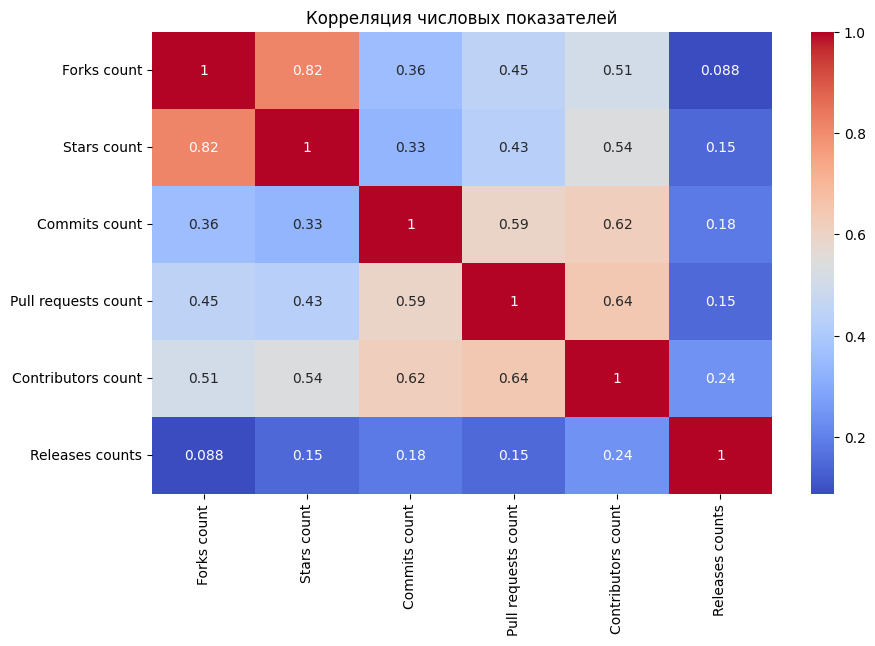

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Корреляция числовых показателей")
plt.show()

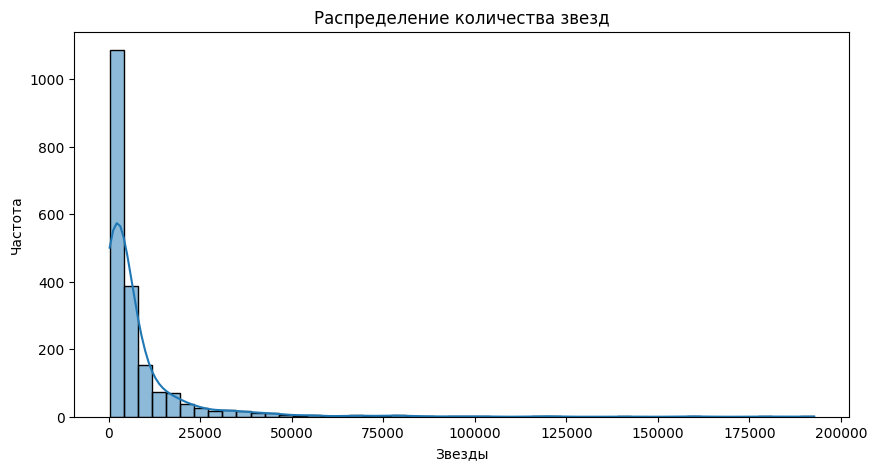

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df["Stars count"], bins=50, kde=True)
plt.title("Распределение количества звезд")
plt.xlabel("Звезды")
plt.ylabel("Частота")
plt.show()


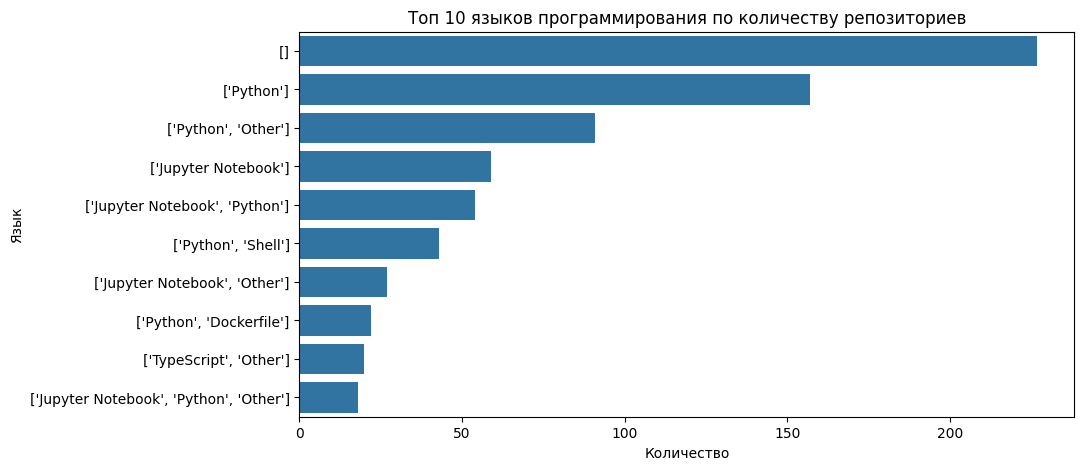

In [ ]:
top_langs = df["Programming languages"].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_langs.values, y=top_langs.index)
plt.title("Топ 10 языков программирования по количеству репозиториев")
plt.xlabel("Количество")
plt.ylabel("Язык")
plt.show()


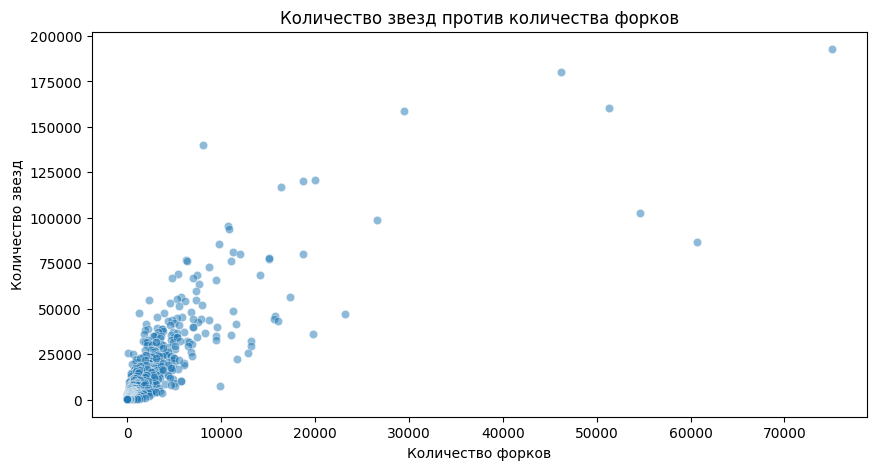

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x="Forks count",
    y="Stars count",
    alpha=0.5
)
plt.title("Количество звезд против количества форков")
plt.xlabel("Количество форков")
plt.ylabel("Количество звезд")
plt.show()


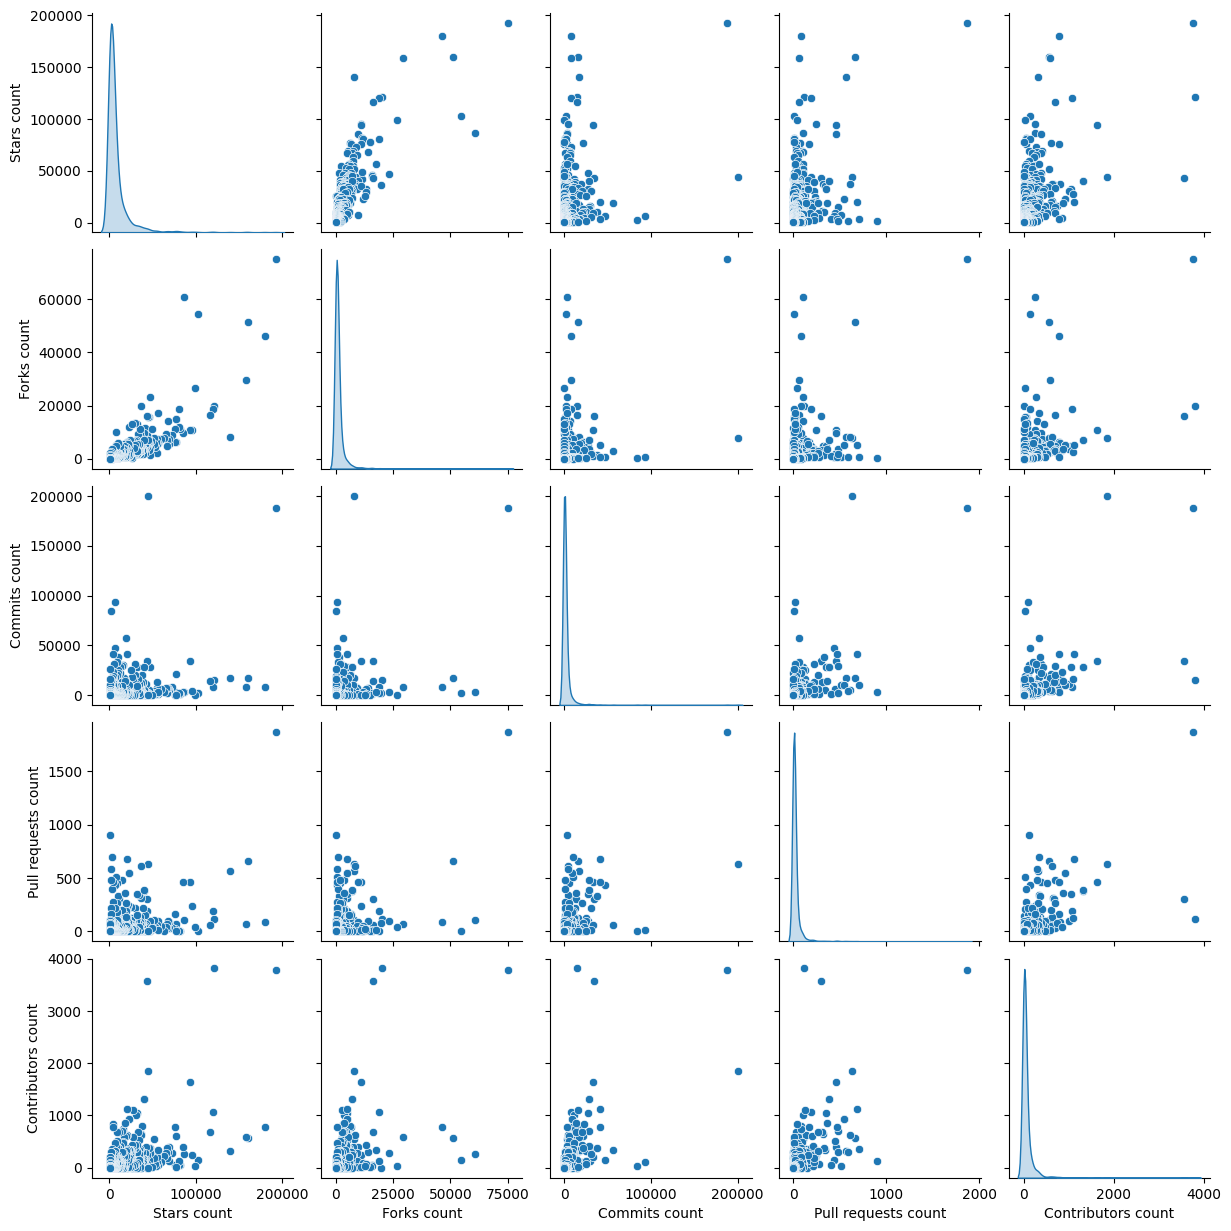

In [ ]:
sns.pairplot(
    df[["Stars count", "Forks count", "Commits count", "Pull requests count", "Contributors count"]],
    diag_kind="kde"
)
plt.show()


Промежуточные выводы:

На основе проведённого EDA и визуализаций можно сформулировать следующие наблюдения:

1. **Общая статистика:**
   - (сюда вписать выводы по describe: медианы, разбросы, порядок величин)

2. **Языки программирования:**
   - (сюда вписать, какие языки чаще встречаются и какие дают больше звёзд в среднем)

3. **Корреляции:**
   - (описать, какие признаки наиболее сильно связаны с количеством звёзд/форков)

4. **Визуализации:**
   - (кратко прокомментировать каждый график: что видно, какие тренды)

Эти выводы будут использованы в финальном разделе проекта (итоговые выводы).
